In [42]:
import requests
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
from sklearn import svm
from sklearn.metrics import (
    classification_report as clrep,
    confusion_matrix as conm,
    f1_score,
    jaccard_score as jss,
    log_loss,
)
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split


### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

In [43]:
url = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv"
requested_file = requests.get(url)
with open("./loan_train.csv","w") as file_:
    file_.write(requested_file.content.decode("utf-8"))
    

### Load Data From CSV File  

In [44]:
df = pd.read_csv("loan_train.csv")

In [45]:
print(f"printing first few lines\n{df.head()}")

printing first few lines
   Unnamed: 0.1  Unnamed: 0 loan_status  Principal  terms effective_date  \
0             0           0     PAIDOFF       1000     30       9/8/2016   
1             2           2     PAIDOFF       1000     30       9/8/2016   
2             3           3     PAIDOFF       1000     15       9/8/2016   
3             4           4     PAIDOFF       1000     30       9/9/2016   
4             6           6     PAIDOFF       1000     30       9/9/2016   

    due_date  age             education  Gender  
0  10/7/2016   45  High School or Below    male  
1  10/7/2016   33              Bechalor  female  
2  9/22/2016   27               college    male  
3  10/8/2016   28               college  female  
4  10/8/2016   29               college    male  


In [46]:
print(f"printing rows and columns\n{df.shape}")

printing rows and columns
(346, 10)


### Convert to date time object 

In [47]:
df["due_date"] = pd.to_datetime(df["due_date"])
df["effective_date"] = pd.to_datetime(df["effective_date"])
print(f"printing first few lines\n {df.head()}")

printing first few lines
    Unnamed: 0.1  Unnamed: 0 loan_status  Principal  terms effective_date  \
0             0           0     PAIDOFF       1000     30     2016-09-08   
1             2           2     PAIDOFF       1000     30     2016-09-08   
2             3           3     PAIDOFF       1000     15     2016-09-08   
3             4           4     PAIDOFF       1000     30     2016-09-09   
4             6           6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  
0 2016-10-07   45  High School or Below    male  
1 2016-10-07   33              Bechalor  female  
2 2016-09-22   27               college    male  
3 2016-10-08   28               college  female  
4 2016-10-08   29               college    male  


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [48]:
print(f"count of each class in our dataset\n{df['loan_status'].value_counts()}")

count of each class in our dataset
PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64


260 people have paid off the loan on time while 86 have gone into collection 


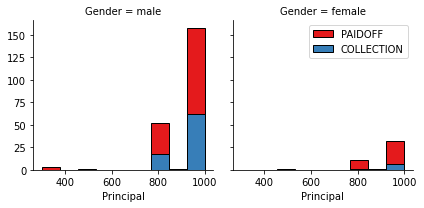

In [49]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
graphs = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
graphs.map(plt.hist, "Principal", bins=bins, ec="k")
graphs.axes[-1].legend()
plt.show()

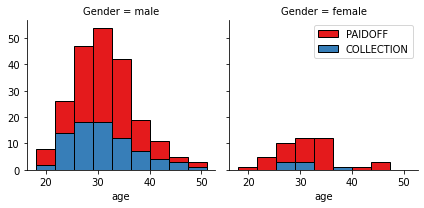

In [50]:
bins2 = np.linspace(df.age.min(), df.age.max(), 10)
graphs2 = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
graphs2.map(plt.hist, "age", bins=bins2, ec="k")
graphs2.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

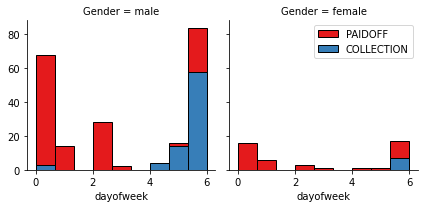

In [51]:
df["dayofweek"] = df["effective_date"].dt.dayofweek
bins3 = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
graphs3 = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
graphs3.map(plt.hist, "dayofweek", bins=bins3, ec="k")
graphs3.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [52]:
df["weekend"] = df["dayofweek"].apply(lambda x: 1 if (x > 3) else 0)
print(df["weekend"])

0      0
1      0
2      0
3      1
4      1
      ..
341    1
342    1
343    0
344    0
345    0
Name: weekend, Length: 346, dtype: int64


## Convert Categorical features to numerical values

Lets look at gender:

In [53]:
group_by_gender = df.groupby(["Gender"])["loan_status"]
print(group_by_gender.value_counts(normalize=True))

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64


Lets convert male to 0 and female to 1:


In [54]:
df["Gender"].replace(to_replace=["male", "female"], value=[0, 1], inplace=True)

## One Hot Encoding  
#### Education

In [55]:
group_by_education = df.groupby(["education"])["loan_status"]
print(group_by_education.value_counts(normalize = True))

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64


#### Feature before One Hot Encoding

In [56]:
print(df[["Principal", "terms", "age", "Gender", "education"]].head())

   Principal  terms  age  Gender             education
0       1000     30   45       0  High School or Below
1       1000     30   33       1              Bechalor
2       1000     15   27       0               college
3       1000     30   28       1               college
4       1000     30   29       0               college


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [57]:
Feature = df[["Principal", "terms", "age", "Gender", "weekend"]]
Feature = pd.concat([Feature, pd.get_dummies(df["education"])], axis=1)
Feature.drop(["Master or Above"], axis=1, inplace=True)
print(Feature.head())

   Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   33       1        0         1                     0   
2       1000     15   27       0        0         0                     0   
3       1000     30   28       1        1         0                     0   
4       1000     30   29       0        1         0                     0   

   college  
0        0  
1        0  
2        1  
3        1  
4        1  


### Feature selection

In [58]:
X = Feature
print(X[:5])

   Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   33       1        0         1                     0   
2       1000     15   27       0        0         0                     0   
3       1000     30   28       1        1         0                     0   
4       1000     30   29       0        1         0                     0   

   college  
0        0  
1        0  
2        1  
3        1  
4        1  


In [59]:
y = df["loan_status"].values
print(y[:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [60]:
X = preprocessing.StandardScaler().fit(X).transform(X)

# Classification 

# K Nearest Neighbor(KNN)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
# for different Ks
Ks = 10
mean_acc = np.zeros((Ks - 1))
std_acc = np.zeros((Ks - 1))
for n in range(1, Ks):
    # Train Model and Predict
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n - 1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n - 1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])
print(mean_acc)

[0.64 0.59 0.74 0.7  0.74 0.71 0.8  0.76 0.74]


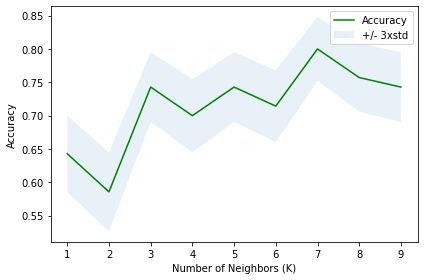

The best accuracy was with 0.8 with k=7


In [62]:
plt.plot(range(1, Ks), mean_acc, "g")
plt.fill_between(
    range(1, Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10
)
plt.legend(("Accuracy", "+/- 3xstd"))
plt.ylabel("Accuracy")
plt.xlabel("Number of Neighbors (K)")
plt.tight_layout()
plt.show()
print(f"The best accuracy was with {mean_acc.max()} with k={mean_acc.argmax()+1}")

In [63]:
# for jaccard and F1 scores
KNN_jaccard = jss(
    y_test, yhat, pos_label = "PAIDOFF"
)  # storing jaccard score in a variable for Report section below
print(f"Jaccard score: {KNN_jaccard}")  # this is the jaccard score

Jaccard score: 0.7313432835820896


In [64]:
KNN_f1_score = f1_score(
    y_test, yhat, average="weighted"
)  # storing F1 score in a variable for Report section below
print(f"Avg F1 score:{KNN_f1_score}")  # this is the F1 score.

Avg F1 score:0.7173645320197043


# Decision Tree

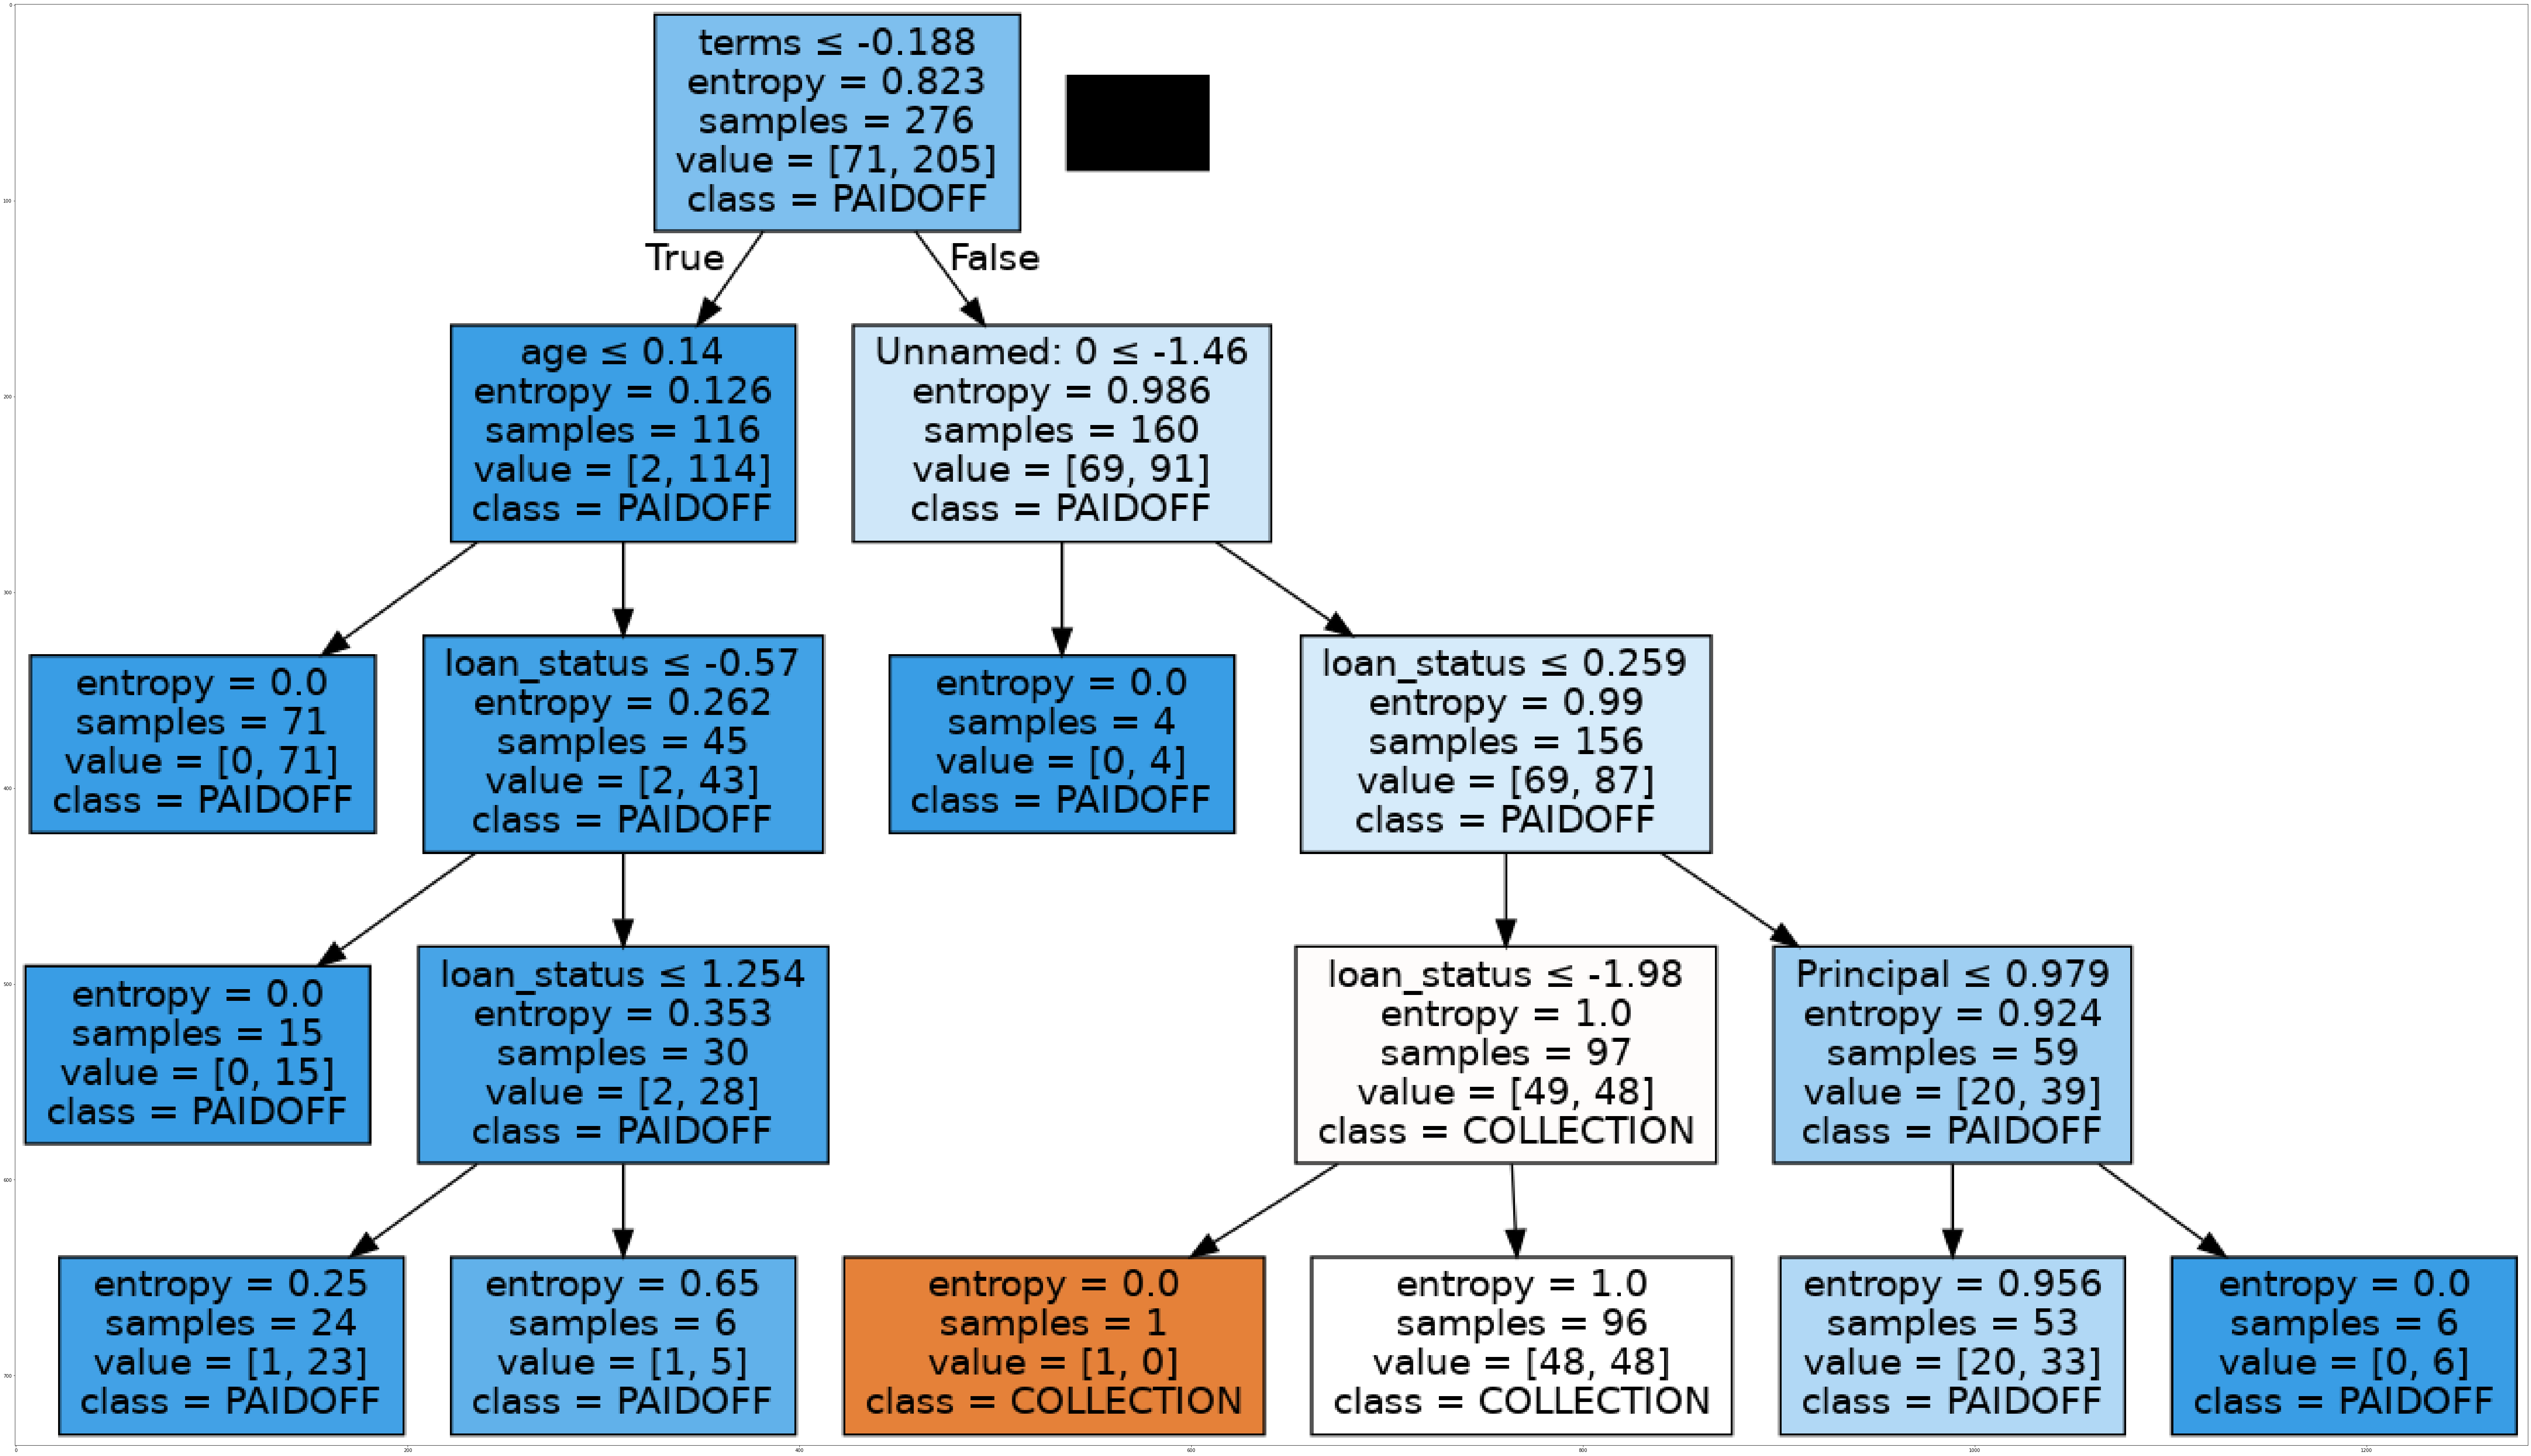

In [65]:
loantree = DecisionTreeClassifier(criterion="entropy", max_depth=4)
loantree.fit(X_train, y_train)  # fitting the training set
predTree = loantree.predict(X_test)  # predicting the testing set
# tree visualization
dot_data = StringIO()
filename = "loantree.png"
featureNames = df.columns[0:8]
target_names_df = df["loan_status"].unique()
targetNames = target_names_df.tolist()
out = tree.export_graphviz(
    loantree,
    feature_names=featureNames,
    out_file=dot_data,
    class_names=np.unique(y_train),
    filled=True,
    special_characters=True,
    rotate=False,
)
data_value = dot_data.getvalue()
tree_graph = pydotplus.graph_from_dot_data(data_value)
tree_graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img, interpolation="nearest")

In [66]:
print(f"DecisionTrees' Accuracy:{metrics.accuracy_score(y_test,predTree)}")

DecisionTrees' Accuracy:0.6142857142857143


In [67]:
# decision tree jaccard and F1 scores
DT_jaccard = jss(
    y_test, predTree, pos_label = "PAIDOFF"
)  # storing jaccard score in a variable for Report section below
print(f"Jaccard score: {DT_jaccard}")  # this is the jaccard score

Jaccard score: 0.5714285714285714


In [68]:
DT_f1_score = f1_score(
    y_test, predTree, average="weighted"
)  # storing F1 score in a variable for Report section below
print(f"Avg F1 score: {DT_f1_score}")  # this is the F1 score.

Avg F1 score: 0.6445993031358885


# Support Vector Machine

In [69]:
# Support Vector machines
loanvm = svm.SVC(kernel="rbf")
loanvm.fit(X_train, y_train)
yhat3 = loanvm.predict(X_test)

In [70]:
def plot_confusion_matrix(
    confumatrix, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        confumatrix = confumatrix.astype("float") / confumatrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(confumatrix)
    plt.imshow(confumatrix, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = confumatrix.max() / 2.0
    for i, j in itertools.product(range(confumatrix.shape[0]), range(confumatrix.shape[1])):
        plt.text(
            j,
            i,
            format(confumatrix[i, j], fmt),
            horizontalalignment="center",
            color="white" if confumatrix[i, j] > thresh else "black",
        )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[ 3 12]
 [ 6 49]]


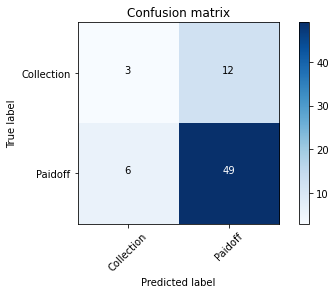

In [71]:
cnf_matrix = conm(y_test, yhat, labels=["COLLECTION", "PAIDOFF"])
np.set_printoptions(precision=2)
# print F1 score
print(clrep(y_test, yhat3))
# plot non normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["Collection", "Paidoff"],
    normalize=False,
    title="Confusion matrix",
)

In [72]:
# storing F1 score value for Report section below
svecm_f1_score = f1_score(y_test, yhat3, average="weighted")
# check F1 score again and jaccard score
f1_score(y_test, yhat, average="weighted")
print(f"Avg F1 score:{svecm_f1_score}")
# storing jaccard score value for Report section below
svecm_jaccard = jss(y_test, yhat3, pos_label= "PAIDOFF")
print(f"Jaccard score: {svecm_jaccard}")

Avg F1 score:0.7275882012724117
Jaccard score: 0.7272727272727273


# Logistic Regression

In [73]:
LR = LogisticRegression(C=0.01, solver="liblinear").fit(X_train, y_train)
yhat2 = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

Confusion matrix, without normalization
[[ 3 12]
 [ 6 49]]


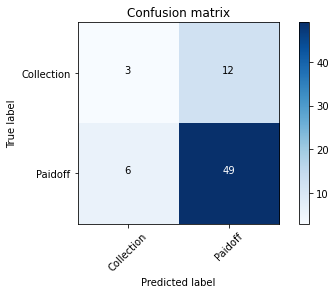

In [74]:
nf_matrix = conm(y_test, yhat2, labels=["COLLECTION", "PAIDOFF"])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["Collection", "Paidoff"],
    normalize=False,
    title="Confusion matrix",
)

In [75]:
# check F1 score value
print(clrep(y_test, yhat2))

              precision    recall  f1-score   support

  COLLECTION       0.18      0.13      0.15        15
     PAIDOFF       0.78      0.84      0.81        55

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70



In [76]:
# check log loss value
print(log_loss(y_test, yhat_prob))

0.5772287609479654


In [77]:
logReg_f1_score = f1_score(y_test, yhat2, average="weighted")
print(f"Avg F1 score:{logReg_f1_score}")
logReg_jaccard = jss(y_test, yhat2, pos_label="PAIDOFF")
print(f"Jaccard score:{logReg_jaccard}")
logReg_logloss = log_loss(y_test, yhat_prob)
print(f"Logloss score: {logReg_logloss}")

Avg F1 score:0.6670522459996144
Jaccard score:0.6764705882352942
Logloss score: 0.5772287609479654


# Report

In [78]:
# create dataframe using following keys and values
data = {
    "Jaccard": [KNN_jaccard, DT_jaccard, svecm_jaccard, logReg_jaccard],
    "F1-score": [KNN_f1_score, DT_f1_score, svecm_f1_score, logReg_f1_score],
    "LogLoss": [None, None, None, logReg_logloss],
}
evaldf = pd.DataFrame(data, index=["KNN", "Decision Tree", "SVM", "LogisticRegression"])
print(evaldf)

                     Jaccard  F1-score   LogLoss
KNN                 0.731343  0.717365       NaN
Decision Tree       0.571429  0.644599       NaN
SVM                 0.727273  0.727588       NaN
LogisticRegression  0.676471  0.667052  0.577229
